In [1]:
import os
import math
# Essential Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# Preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
# Algorithms
from minisom import MiniSom
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, r2_score
import sqlite3
from datetime import datetime
import matplotlib.dates as mdates


In [2]:
def requete_sql (requete) :
    try:
        connexion = sqlite3.connect('./data/liste_piezos.db')
        curseur = connexion.cursor()
        print("Connexion réussie à SQLite")
        curseur.execute(requete)
        connexion.commit()
        resultat = curseur.fetchall()
        curseur.close()
        connexion.close()
        print("Connexion SQLite est fermée")
        return resultat
    except sqlite3.Error as error:
        print("Erreur lors du mis à jour dans la table", error)

# Import des données
## Sélection des piezos

Récupération des codes_bss par jointure de tables dans la base de données

In [5]:
region = "HDF"

requete = f"""
        SELECT code_bss
        FROM data_piezo
        INNER JOIN code_region
            ON code_dpt = departement
        WHERE code_region IS '{region}'
        AND fichier_piezo IS 1
         """
data = requete_sql(requete)
code_bss = []
for code in data:
    code_bss.append(code[0]) 

Connexion réussie à SQLite
Connexion SQLite est fermée


In [6]:
code_bss

['00327X0059_P11',
 '00387X0184_PZCC1',
 '00276X0030_F1',
 '00277X0011_F1',
 '00281X0002_F1',
 '00124X0023_F1',
 '00207X0133_F1',
 '00281X0004_F1',
 '00146B0007_F1',
 '00155C0017_F1',
 '00143A0008_F1',
 '00143C0079_F1',
 '00471X0010_H1',
 '00463X0036_H1',
 '00035X0210_PZO1',
 '00182X0010_P1',
 '00512X0001_P1',
 '00167X0001_P1',
 '00115X0011_P1',
 '00065X0011_P1',
 '00291X0031_P1',
 '00171X0051_P1',
 '00113X0002_P1',
 '00241X0012_P1',
 '00365X0003_P1',
 '00117X0023_P1',
 '00198X0123_P1',
 '00104X0054_P1',
 '00275X0005_P1',
 '00248X0005_P1',
 '00263X0006_P1',
 '00107X0006_P1',
 '00367X0026_P1',
 '00172X0037_P1',
 '00286X0037_P1',
 '00147D0218_P1',
 '00296X0158_P1',
 '00217X0068_P1',
 '00258X0009_P1',
 '00035X0029_P1',
 '00067X0029_P1',
 '00792X0010_S1',
 '00125X0010_S1',
 '01046X0010_S1',
 '00855X0001_S1',
 '01568X0101_S1',
 '00346X0011_S1',
 '00794X0021_S1',
 '00377X0051_S1',
 '00493X0061_S1',
 '01293X0071_S1',
 '00805X0002_S1',
 '00625X0002_S1',
 '00245X0002_S1',
 '00341X0012_S1',
 '00

## Construction d'un dataframe

In [7]:
directory = './data/piezo/'

# Lecture des données du premier piezo de la liste pour initialiser le dataframe
data = pd.read_csv(directory+f"{code_bss[0]}.csv", sep=";",  index_col=0, parse_dates=True)
data.rename(columns={"piezo":f"{code_bss[0]}"}, inplace=True)

custom_date_parser = lambda x: datetime.strptime(x, "%Y-%m-%d")

for file in code_bss[1:]:
    df = pd.read_csv(f"{directory+file}.csv", sep=";",  index_col=0, parse_dates=True, date_parser=custom_date_parser)
    df.rename(columns={"piezo":f"{file}"}, inplace=True)
    data = pd.merge(data,df,left_index=True, right_index=True,how='outer')

In [8]:
data

00327X0059_P11  00387X0184_PZCC1  00276X0030_F1  00277X0011_F1  \
date_mesure                                                                   
1899-03-28              NaN               NaN            NaN            NaN   
1899-05-10              NaN               NaN            NaN            NaN   
1899-05-19              NaN               NaN            NaN            NaN   
1899-07-09              NaN               NaN            NaN            NaN   
1899-07-30              NaN               NaN            NaN            NaN   
...                     ...               ...            ...            ...   
2022-05-26           -27.54             -3.22         -15.85            NaN   
2022-05-27           -27.58             -3.23         -15.83            NaN   
2022-05-28           -27.62             -3.25         -15.83            NaN   
2022-05-29           -27.65             -3.24         -15.86            NaN   
2022-05-30           -27.68             -3.24         -15.90            NaN   

             00281X0002_F1  00124X0023_F1  00207X0133_F1  00281X0004_F1  \
date_mesure                                                               
1899-03-28             NaN            NaN            NaN            NaN   
1899-05-10             NaN            NaN            NaN            NaN   
1899-05-19             NaN            NaN            NaN            NaN   
1899-07-09             NaN            NaN            NaN            NaN   
1899-07-30             NaN            NaN            NaN            NaN   
...                    ...            ...            ...            ...   
2022-05-26           -8.58         -19.66          -2.39         -28.48   
2022-05-27           -8.51         -19.67          -2.39         -28.52   
2022-05-28           -8.54         -19.69          -2.37         -28.54   
2022-05-29           -8.45         -19.69          -2.35         -28.57   
2022-05-30           -8.44         -19.70          -2.36         -28.59   

             00146B0007_F1  00155C0017_F1  ...  00611X0017_P  00815X0067_P  \
date_mesure                                ...                               
1899-03-28             NaN            NaN  ...           NaN           NaN   
1899-05-10             NaN            NaN  ...           NaN           NaN   
1899-05-19             NaN            NaN  ...           NaN           NaN   
1899-07-09             NaN            NaN  ...           NaN           NaN   
1899-07-30             NaN            NaN  ...           NaN           NaN   
...                    ...            ...  ...           ...           ...   
2022-05-26           -4.24          -5.84  ...        -40.30        -19.27   
2022-05-27           -4.26          -5.86  ...        -40.32        -19.31   
2022-05-28           -4.26          -5.87  ...        -40.33        -19.38   
2022-05-29           -4.24            NaN  ...        -40.33        -19.41   
2022-05-30             NaN            NaN  ...        -40.34        -19.47   

             00326X0018_P  00065X0148_P  01285X0058_P  00252X0019_P  \
date_mesure                                                           
1899-03-28            NaN           NaN           NaN           NaN   
1899-05-10            NaN           NaN           NaN           NaN   
1899-05-19            NaN           NaN           NaN           NaN   
1899-07-09            NaN           NaN           NaN           NaN   
1899-07-30            NaN           NaN           NaN           NaN   
...                   ...           ...           ...           ...   
2022-05-26         -31.26         -1.72           NaN           NaN   
2022-05-27         -31.28         -1.75           NaN           NaN   
2022-05-28         -31.29         -1.77           NaN           NaN   
2022-05-29         -31.30         -1.82           NaN           NaN   
2022-05-30         -31.31         -1.82           NaN           NaN   

             00615X0019_P  00331X0051_F.SEP  BSS003RMMC_X  00616X0040_

## Visualisation des valeurs manquantes

In [9]:
# Fonction d'affichage des valeurs manquantes
def f_plot_nan (dataframe):
    f, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,6))
    sns.heatmap(dataframe.T.isna(), cmap='Blues', cbar=False)
    ax.set_title('Missing Values', fontsize=16)
    # Masquage des noms de piezo 
    ax.yaxis.set_visible(False)
    # Formatage de la date pour l'affichage
    ax.xaxis.set_ticklabels([pd.to_datetime(value).strftime('%Y') for value in ax.xaxis.get_major_formatter().func.args[0].values()])
    plt.show()

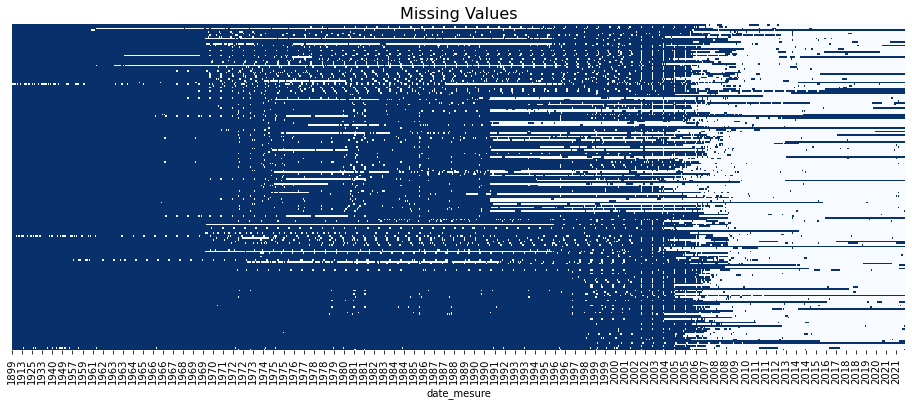

In [10]:
f_plot_nan(data)

# Traitement des données

## Rééchantillonnage à la semaine

In [11]:
data_week = pd.DataFrame(data.resample('7D').mean())

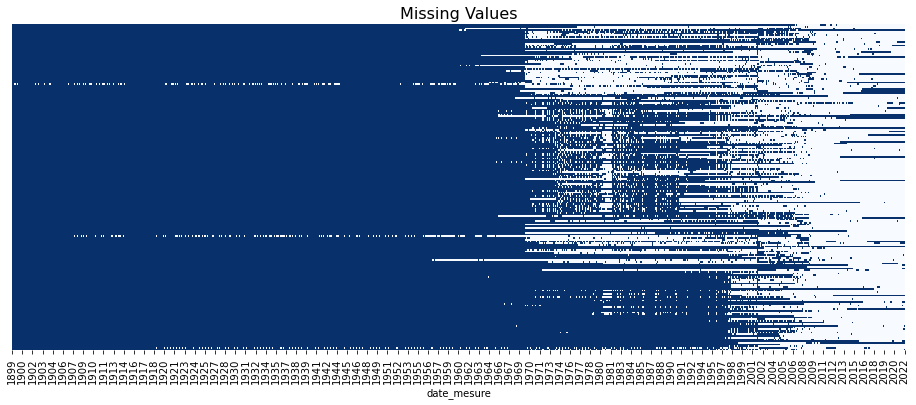

In [12]:
f_plot_nan(data_week)

In [13]:
data_week.shape

(6427, 193)

## Echelle de temps fixée après 2009 pour limiter les Nan

In [16]:
data_week_from_ = data_week.loc['01-01-2009':]

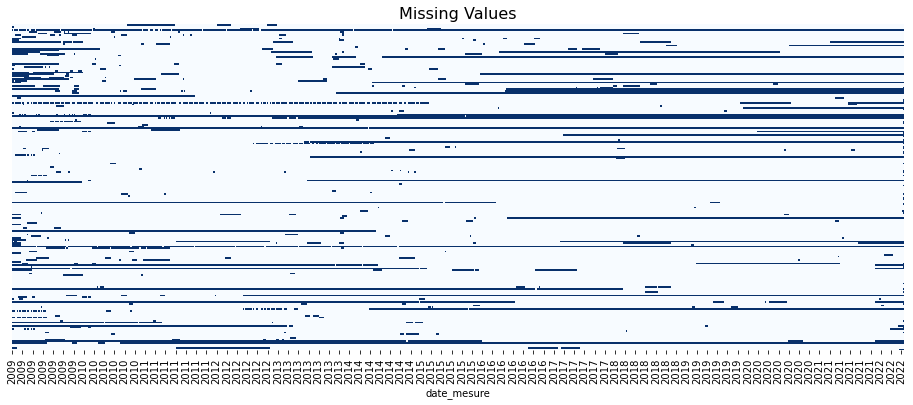

In [17]:
f_plot_nan(data_week_from_)

## Suppression des valeurs abbérantes
Utilisation de la méthode IQR pour supprimer les valeurs abbérantes.
- Calcul des quartiles et de l'écart interquartile
- Suppression des valeurs < Q1 - 1.5*IQR
- Suppression des valeurs > Q3 + 1.5*IQR

In [18]:
nbre_na = data_week_from_.isna().sum().sum()
print(f"Il y a à ce stade {nbre_na} valeurs nulles dans l'ensemble du dataframe.")

Il y a à ce stade 16646 valeurs nulles dans l'ensemble du dataframe.


In [19]:
data_wo_outliers = data_week_from_.copy()

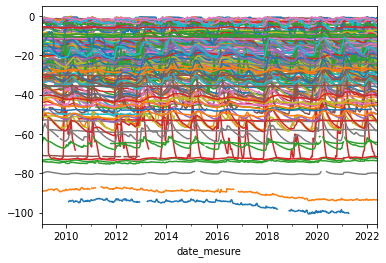

In [20]:
for piezo in data_wo_outliers.columns : 
    q1 = np.nanquantile(data_wo_outliers[f"{piezo}"], .25)
    q3 = np.nanquantile(data_wo_outliers[f"{piezo}"], .75)
    IQR = q3-q1
    data_wo_outliers.loc[data_wo_outliers[f"{piezo}"] < (q1-1.5*IQR), piezo] = np.NaN
    data_wo_outliers.loc[data_wo_outliers[f"{piezo}"] > (q3+1.5*IQR), piezo] = np.NaN
    data_wo_outliers[f"{piezo}"].plot()

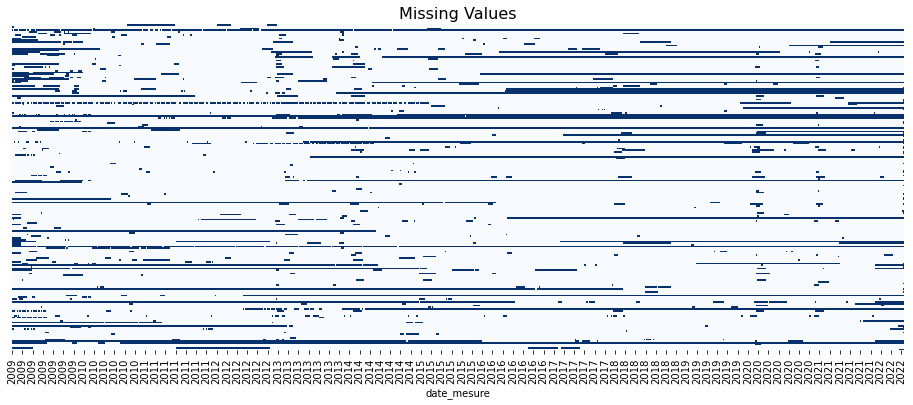

In [21]:
f_plot_nan(data_wo_outliers)

In [22]:
nbre_na_2 = data_wo_outliers.isna().sum().sum()
print(f"Il y a à ce stade {nbre_na_2} valeurs nulles dans l'ensemble du dataframe.")

Il y a à ce stade 17909 valeurs nulles dans l'ensemble du dataframe.


## Suppression des piezos avec plus de 5% de valeurs manquantes

In [23]:
# Liste des piezos avec plus de 10% de valeurs manquantes
bss_to_drop = data.loc[:,data_wo_outliers.isna().sum()>0.05*data_wo_outliers.shape[0]].columns

In [24]:
data_clean = data_wo_outliers.copy().drop(bss_to_drop, axis=1)

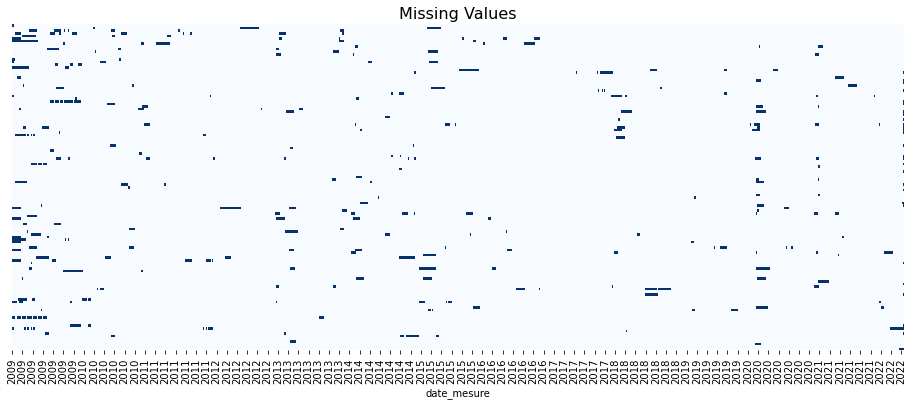

In [25]:
f_plot_nan(data_clean)

In [26]:
nbre_na_3 = data_clean.isna().sum().sum()
print(f"Il y a à ce stade {nbre_na_3} valeurs nulles dans l'ensemble du dataframe.")

Il y a à ce stade 1236 valeurs nulles dans l'ensemble du dataframe.


In [27]:
data_clean.shape

(699, 125)

## Interpolation

In [28]:
data_interpol = data_clean.copy().interpolate('linear')

In [29]:
data_interpol.shape

(699, 125)

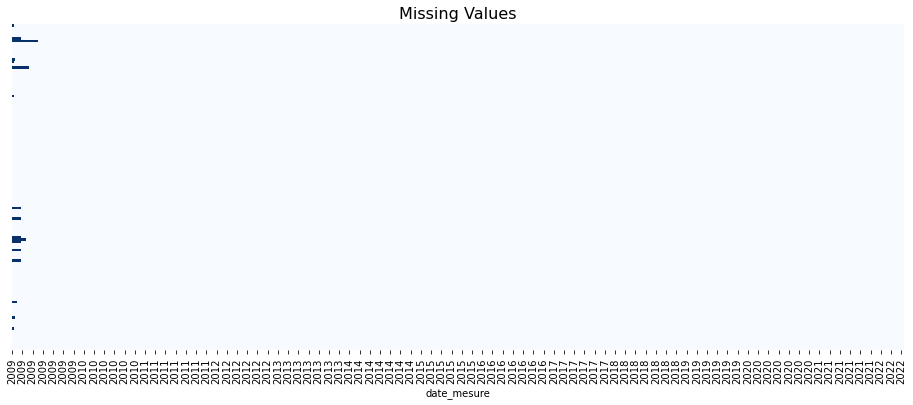

In [30]:
f_plot_nan(data_interpol)

## Réajustement des dates de début et de fin

In [31]:
debut = []
for column in data_interpol.columns:
    debut.append(data_interpol[f"{column}"].first_valid_index())
date_debut = max(debut)

In [32]:
fin = []
for column in data_interpol.columns:
    fin.append(data_interpol[f"{column}"].last_valid_index())
date_fin = min(fin)
date_fin

Timestamp('2022-05-24 00:00:00', freq='7D')

In [33]:
data_interpol = data_interpol.loc[date_debut:date_fin]

In [34]:
print(f"Nombre total de Nan : {data_interpol.isna().sum().sum()}")

Nombre total de Nan : 0


In [35]:
data_interpol.shape

(678, 125)

In [36]:
data_interpol.shape[1]

125

## Affichage des chroniques après nettoyage

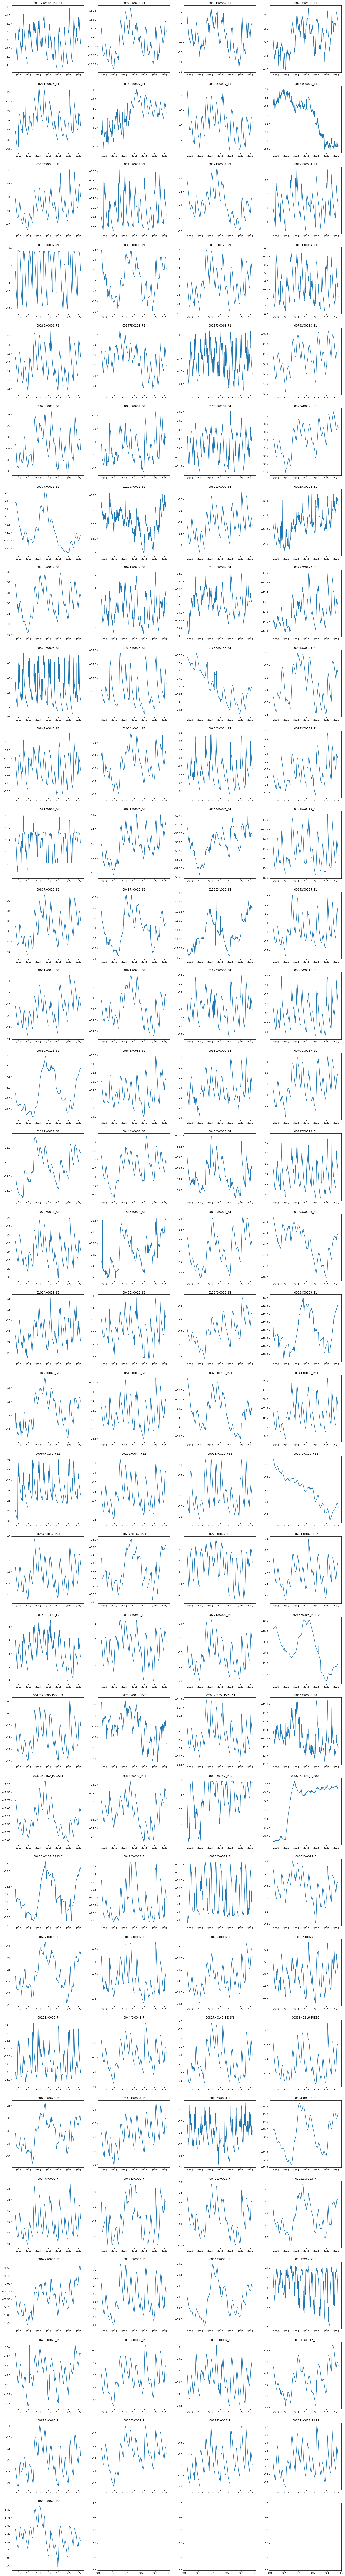

In [37]:
if data_interpol.shape[1]%4 == 0:
    nbre_lignes = data_interpol.shape[1]//4
else : 
    nbre_lignes = data_interpol.shape[1]//4 + 1

fig, axs = plt.subplots(nbre_lignes,4,figsize=(25,200))
#fig.suptitle('Series')
for i in range(nbre_lignes):
    for j in range(4):
        if i*4+j+1>data_interpol.shape[1]: # pass the others that we can't fill
            continue
        axs[i, j].plot(data_interpol.iloc[:,i*4+j])
        axs[i, j].set_title(data_interpol.columns[i*4+j])
plt.show()

## Normalisation StandardScaler

In [38]:
def scaleColumns(df):
    for col in df.columns:
        df[col] = pd.DataFrame(scaler.fit_transform(pd.DataFrame(df[col])),columns=[col], index=df.index)
    return df

In [39]:
scaler = StandardScaler()
data_norm = scaleColumns(data_interpol.copy())

In [40]:
data_norm.head()

00387X0184_PZCC1  00276X0030_F1  00281X0002_F1  00207X0133_F1  \
date_mesure                                                                  
2009-06-02           0.668895       0.972150       1.594150      -0.021698   
2009-06-09           0.494642       0.860003       1.509325      -0.135389   
2009-06-16           0.338170       0.733385       1.432878      -0.230131   
2009-06-23           0.208369       0.661033       1.281030      -0.381719   
2009-06-30           0.050119       0.512709       0.971051      -0.609101   

             00281X0004_F1  00146B0007_F1  00155C0017_F1  00143C0079_F1  \
date_mesure                                                               
2009-06-02       -0.813591      -1.094842       2.523251       0.900194   
2009-06-09       -0.886079      -1.272858       2.442602       0.882170   
2009-06-16       -0.964059      -1.448852       2.346737       0.854489   
2009-06-23       -1.058513      -1.339614       2.223481       0.757930   
2009-06-30       -1.162852      -1.345683       2.107834       0.567386   

             00463X0036_H1  00115X0011_P1  ...  00512X0206_P  00453X0026_P  \
date_mesure                                ...                               
2009-06-02        0.637469      -0.452192  ...      0.719928      1.461109   
2009-06-09        0.518079      -0.518557  ...      0.701715      1.380511   
2009-06-16        0.401874      -0.599629  ...      0.415088      1.274726   
2009-06-23        0.285668      -0.677832  ...      0.256916      1.229390   
2009-06-30        0.183789      -0.745990  ...      0.067110      1.168942   

             00332X0036_P  00836X0007_P  00611X0017_P  00815X0067_P  \
date_mesure                                                           
2009-06-02       0.260467      0.481473      0.945143     -0.455786   
2009-06-09       0.185835      0.391354      0.948522     -0.507628   
2009-06-16       0.092206      0.314109      0.852757     -0.510300   
2009-06-23       0.004005      0.211115      0.845998     -0.594209   
2009-06-30      -0.080125      0.146744      0.777272     -0.633759   

             00326X0018_P  00615X0019_P  00331X0051_F.SEP  00616X0040_PZ  
date_mesure                                                               
2009-06-02       0.401771     -0.385778         -0.038193       0.597813  
2009-06-09       0.354533     -0.456482         -0.131528       0.551708  
2009-06-16       0.309237     -0.540995         -0.200301       0.478709  
2009-06-23       0.266530     -0.613909         -0.321473       0.421077  
2009-06-30       0.223175     -0.685717         -0.429954       0.355762  

[5 rows x 125 columns]

## Sauvegarde du dataframe en csv

In [41]:
data_norm.to_csv(f"./data/piezo_clustering/{region}.csv", sep = ";")